# Библиотеки и функции

In [1]:
import numpy as np
import scipy
import pandas as pd
from pandas import Series
from collections import Counter
import json
import re
from datetime import datetime, date, time

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import scipy.sparse as sparse

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.feature_selection import f_classif, mutual_info_classif

from wordcloud import WordCloud, STOPWORDS 
import string
import re
import nltk
from nltk.util import ngrams
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from textblob import TextBlob

import itertools
import ast
from itertools import combinations
from scipy.stats import ttest_ind, pearsonr

from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
# import nmslib

/kaggle/input/metadata-prep/meta_prep.csv
/kaggle/input/recommendationsv4/sample_submission.csv
/kaggle/input/recommendationsv4/train.csv
/kaggle/input/recommendationsv4/test.csv
/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json


In [2]:
#pip install nmslib

In [3]:
# Полезные функции

# Определение выбросов
def get_outlier(df, col):
    Q3 = pd.DataFrame.quantile(df, q=0.75, axis=0, numeric_only=True, interpolation='midpoint')[col]
    Q1 = pd.DataFrame.quantile(df, q=0.25, axis=0, numeric_only=True, interpolation='midpoint')[col]
    IQR = round(Q3-Q1,1)
    return df[~df[col].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)][col], Q1 - 1.5*IQR, Q3 + 1.5*IQR

# Информация о выбросах с графиками
def show_info(df, col, show=True):
    # Выводим количество выбросов и их границы
    out, lim1, lim2 = get_outlier(df, col)
    minCol = df[col].min()
    maxCol = df[col].max()
    median = df[col].median()
    nulCol = sum(pd.isnull(df[col]))
    
    cnt = min(int(df[col].value_counts().count()),2000)
    
    if show:
        print('Не заполнено: ', nulCol)
        print('Минимум: ', minCol)
        print('Максимум: ', maxCol)
        print('Медиана: ', median)
        print('Количество выбросов: ', len(out))
        if len(out) > 0:
            print('Нижняя граница выбросов: ', lim1)
            print('Верхняя граница выбросов: ', lim2)

        # Выводим графики: гистограмму и боксплот
        fig, axes = plt.subplots(1,2,figsize=(12,4))
        axes[0].hist(df[col], bins=cnt)
        axes[1].boxplot(df[col])
    
    return {'med': median, 'lm1': lim1, 'lm2': lim2}

# Сбор информации о всех данных
def describe_data(df):
    information = pd.DataFrame(columns=['name','type','count','isnull','unique',
                                    'min','max','mean','mode',
                                    '25','50','75', 'len_out', 'out_1','out_2'
                                       ])
    types = df.dtypes
    columns = df.columns
    for col in columns:
        mode = np.NaN
        try:  
            mode = df[col].mode()[0]
        except:  
            pass
        
    
        if str(df.dtypes[col]) == 'object' or str(df.dtypes[col]) == 'bool':
            information.loc[len(information)] = [col, 
                                         str(df.dtypes[col]), 
                                         len(df[~df[col].isnull()]), 
                                         len(df[df[col].isnull()]), 
                                         len(df[col].unique()), 
                                         np.NaN, 
                                         np.NaN, 
                                         np.NaN, 
                                         mode ,
                                         np.NaN, 
                                         np.NaN, 
                                         np.NaN,
                                         np.NaN,
                                         np.NaN,
                                         np.NaN
                                                ] 
        else:
            out, lim1, lim2 = get_outlier(df, col)
            if len(out) == 0:
                lim1 = np.NaN
                lim2 = np.NaN
    
            information.loc[len(information)] = [col, 
                                         str(df.dtypes[col]), 
                                         df.describe().loc['count',col], 
                                         len(df[df[col].isnull()]), 
                                         len(df[col].unique()), 
                                         df.describe().loc['min',col], 
                                         df.describe().loc['max',col], 
                                         df.describe().loc['mean',col], 
                                         mode,
                                         df.describe().loc['25%',col], 
                                         df.describe().loc['50%',col], 
                                         df.describe().loc['75%',col],
                                         len(out),
                                         lim1,
                                         lim2
                                                ] 
    return information 

def describe_data_short(df):
    information = pd.DataFrame(columns=['name','type','count','isnull','unique','mode'])
    types = df.dtypes
    columns = df.columns
    for col in columns:
        mode = np.NaN
        try:  
            mode = df[col].mode()[0]
        except:  
            pass
        
        unique = np.NaN
        try:  
            unique = len(df[col].unique())
        except:  
            pass
        
        information.loc[len(information)] = [col, 
                                         str(df.dtypes[col]), 
                                         len(df[~df[col].isnull()]), 
                                         len(df[df[col].isnull()]), 
                                         unique, 
                                         mode] 
         
    return information 

# Сравнение двух графиков 
def val_log_plot(df, col):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].hist(df[col], rwidth=0.9, alpha=0.7, bins=15)
    ax[0].set_title(col)

    ax[1].hist(np.log(df[col]+1), rwidth=0.9, alpha=0.7, bins=15)
    ax[1].set_title('log of '+col)

    plt.show()


# Визуализация результатов модели
def graph_roc_auc(y_true, y_pred_prob):
    fpr, tpr, threshold = roc_curve(y_true, y_pred_prob)
    roc_auc = roc_auc_score(y_true, y_pred_prob)
 
    plt.figure(figsize=(4, 4))
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('LightFM ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()


    
# Преобразование в None для строковых признаков
def set_None(value):
    if value is None:
        return value
    else:        
        str_value = str(value).strip()
        if str_value == '' or str_value.lower() == 'nan':
            return None
        else:
            return str_value


# перевод в нижний регистр
def set_lower(value):
    if value is None:
        return value
    else:
        return value.lower()
    

# Получение самых популярных элементов списков
def get_top_bottom(column, percent):
    lst_temp = list(column.value_counts())
    tmp_sum = 0
    all_sum = sum(lst_temp)
    top_index = 0

    for cnt in lst_temp:
        tmp_sum += cnt
        if tmp_sum >= all_sum * percent/100:
            top_index = lst_temp.index(cnt)
            break;

    all_val = column.value_counts().index
    top_val = list(all_val)[:top_index]
    bottom_val = list(set(all_val) - set(top_val))

    return top_val, bottom_val

# функция вычисления попарного p_value при множественном значении категориального столбца
def get_stat_dif(df, columns, col_target):
    
    p_list =[]
    res = '' 
    for col in columns:
        cols = df.loc[:, col].value_counts().index
        combinations_all = list(combinations(cols, 2))
        if len(combinations_all)==0:
            res = col + ': значимости нет'
            print(res)
            continue
        
        conv = 0.05 / len(combinations_all) # пороговый уровень значимости с поправкой Бонферрони
    
        for comb in combinations_all:
            p_value = ttest_ind(df.loc[df.loc[:, col] == comb[0], col_target], 
                     df.loc[df.loc[:, col] == comb[1], col_target]).pvalue
            p_list.append(p_value)
        
            if p_value < conv:
                res = ', значимость есть: для ' + str(comb) + ' p_value=' + str(p_value)
            else:
                res = ', значимости нет'
            break
            
        if res == '':
            res = ', значимости нет: min(p_value)=' + str(min(p_list))
    
        res = col + ': порог=' + str(round(conv,6)) + res
        print(res)
        

# функция выявления значимости числовых столбцов по корреляции по Пирсону
def get_stat_corr(df, columns, col_target):
    
    for col in columns:
        p_value = pearsonr(df[col], df[col_target])[1]
    
        if (p_value / len(columns)) < 0.05:
            print(col + ' для ' + col_target + ' - значимость есть')
        else:
            print(col + ' для ' + col_target + ' - значимости нет')

# Чтение данных

overall - рейтинг, который поставил пользователь   
verified - был ли отзыв верифицирован   
reviewTime - когда был отзыв написан   
reviewerName - имя пользователя   
reviewText - текст отзыва   
summary - сжатый отзыв   
vote - количество голосований за отзыв   
style - метаданные   
image - изображение продукта   
userid - id пользователя   
itemid - id товара   
id - id для предсказания   

In [4]:
# Читаем данные
train = pd.read_csv('/kaggle/input/recommendationsv4/train.csv')
test = pd.read_csv('/kaggle/input/recommendationsv4/test.csv')
submission = pd.read_csv('/kaggle/input/recommendationsv4/sample_submission.csv')

In [5]:
# Читаем файл с метаданными, подготовленный на стороне ради ускорения процесса
meta = pd.read_csv('/kaggle/input/metadata-prep/meta_prep.csv')

In [6]:
print(train.columns)
print(test.columns)

Index(['overall', 'verified', 'reviewTime', 'asin', 'reviewerName',
       'reviewText', 'summary', 'unixReviewTime', 'vote', 'style', 'image',
       'userid', 'itemid', 'rating'],
      dtype='object')
Index(['verified', 'reviewTime', 'asin', 'reviewerName', 'unixReviewTime',
       'vote', 'style', 'image', 'userid', 'itemid', 'Id'],
      dtype='object')


В тренировочном наборе есть столбцы, которые отсутствуют в тестовом:   
overall - оценка по пятибалльной шкале   
reviewText - текст отзыва   
summary - краткое содержание отзыва   
rating - предсказываемая переменная   

Зато в тестовом наборе есть столбец Id, которого нет в тренировочном.

In [7]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 54 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   category          283512 non-null  object 
 1   description       248546 non-null  object 
 2   title             283508 non-null  object 
 3   brand             287209 non-null  object 
 4   rank              287209 non-null  object 
 5   also_view         287209 non-null  object 
 6   main_cat          287209 non-null  object 
 7   price             287209 non-null  float64
 8   asin              283512 non-null  object 
 9   also_buy          287209 non-null  object 
 10  category_len      283512 non-null  float64
 11  category_len_out  283512 non-null  float64
 12  cat1              283512 non-null  float64
 13  cat2              283512 non-null  float64
 14  cat3              283512 non-null  float64
 15  cat4              283512 non-null  float64
 16  cat5              28

# Анализ и подготовка данных

## Общий обзор

In [8]:
# Удалим дубликаты в meta
meta = meta.drop_duplicates()
meta.shape

(286159, 54)

In [9]:
# Доработаем данные о товарах
# Заполним пропуски
meta.category_len = meta.category_len.astype('Int32')
meta.category_len = meta.category_len.fillna(0)
meta.cat_other = meta.cat_other.fillna(0)

for i in range(1,21):
    meta['cat'+str(i)] = meta['cat'+str(i)].fillna(0)
    
meta.title = meta.title.apply(set_None)
meta.title = meta.apply(lambda row: row['title'] if not (row['title'] is None) \
                        else 'Unknown item brand of '+row['brand'] if row['brand']!='Unknown' \
                        else 'Unknown item', axis=1)

In [10]:
# Подчистим плохие названия товара
# Название можно вытащить и из js-кода, который подсунут вместо названия,
# и частично из описания, например так:  description[:50],
# но обойдемся примитивным решением
meta.title = meta.apply(lambda row: row['title'] if not ('var aP' in row['title']) \
                        else 'Unknown item brand of '+row['brand'] if row['brand']!='Unknown' \
                        else 'Unknown item', axis=1)
meta[meta.title.str.contains('var aP')]
print(meta.iloc[31885].title)

Unknown item brand of Escape Concepts


In [11]:
# Удалим столбцы с картинками
train = train.drop(['image'], axis=1)
test = test.drop(['image'], axis=1)

In [12]:
# Добавим в тренировочный и тестовый датафреймы данные из файла json
mtrain = pd.merge(train, meta, on='asin', how="left")
mtest = pd.merge(test, meta, on='asin', how="left")

# Проверяем по полю без пропусков 'category', все ли идентификаторы из train и test есть в meta
print(len(mtrain[mtrain.category.isnull()]))
print(len(mtest[mtest.category.isnull()]))

0
0


In [13]:
# Проверим количество строк в новых и старых наборах
len(train), len(mtrain), len(test), len(mtest)

(857895, 857895, 285965, 285965)

Видно, что left join не задублировал записи и нет пустых значений поля 'category'. Значит,для каждой строки в test и train нашлась ровно одна строка в метаданных.

In [14]:
# Получим сводную информацию о данных
train_info = describe_data_short(train)
test_info = describe_data_short(test)
display(train_info)
display(test_info)

,name,type,count,isnull,unique,mode
0,overall,float64,857895,0,5,5
1,verified,bool,857895,0,2,1
2,reviewTime,object,857895,0,4580,"03 1, 2016"
3,asin,object,857895,0,41302,B00BUKL666
4,reviewerName,object,857719,176,101208,Amazon Customer
5,reviewText,object,857616,279,686740,good
6,summary,object,857725,170,411452,Five Stars
7,unixReviewTime,int64,857895,0,4580,1456790400
8,vote,object,118740,739155,478,2
9,style,object,444406,413489,25893,{'Size:': ' Pack of 1'}


,name,type,count,isnull,unique,mode
0,verified,bool,285965,0,2,True
1,reviewTime,object,285965,0,4349,"03 1, 2016"
2,asin,object,285965,0,37876,B00BUKL666
3,reviewerName,object,285918,47,86816,Amazon Customer
4,unixReviewTime,int64,285965,0,4349,1456790400
5,vote,object,39462,246503,305,2
6,style,object,147680,138285,18905,{'Size:': ' Pack of 1'}
7,userid,int64,285965,0,109357,842
8,itemid,int64,285965,0,37876,22208
9,Id,int64,285965,0,285965,0


## Overall

In [15]:
display(train_info[train_info.name=='overall'])
display(train['overall'].value_counts())

,name,type,count,isnull,unique,mode
0,overall,float64,857895,0,5,5


5.0    615196
4.0    113094
3.0     60440
1.0     37498
2.0     31667
Name: overall, dtype: int64

В столбце подавляющее большинство оценок - 5. Cтолбца нет в test. Пока оставим, он может пригодится для предсказания с фичами.

In [16]:
train['overall'] = train['overall'].astype('int32')

## verified

In [17]:
display(train_info[train_info.name=='verified'])
display(train.verified.value_counts())
display(test_info[test_info.name=='verified'])
display(test.verified.value_counts())

,name,type,count,isnull,unique,mode
1,verified,bool,857895,0,2,1


True     745243
False    112652
Name: verified, dtype: int64

,name,type,count,isnull,unique,mode
0,verified,bool,285965,0,2,True


True     248604
False     37361
Name: verified, dtype: int64

Пропуски в столбцах отсутствуют.

In [18]:
# Превратим значения в целые числа
train['verified'] = train['verified'].astype('int32')
test['verified'] = test['verified'].astype('int32')

## reviewTime и unixReviewTime

In [19]:
# Глянем на вид данных
print(train.iloc[1267].reviewTime, type(train.iloc[1267].reviewTime))

01 22, 2016 <class 'str'>


In [20]:
display(train.reviewTime.value_counts())

03 1, 2016     942
07 14, 2016    885
06 3, 2015     799
01 20, 2016    795
02 20, 2016    784
              ... 
06 8, 2006       1
01 29, 2006      1
01 25, 2005      1
11 25, 2006      1
08 9, 2000       1
Name: reviewTime, Length: 4580, dtype: int64

In [21]:
# Приведем к типу даты и посмотрим на разброс значений
train['reviewTime'] = train['reviewTime'].apply(lambda x: datetime.strptime(x,'%m %d, %Y'))
train['reviewTime'].min(), train['reviewTime'].max()

(Timestamp('2000-08-09 00:00:00'), Timestamp('2018-10-02 00:00:00'))

In [22]:
test['reviewTime'] = test['reviewTime'].apply(lambda x: datetime.strptime(x,'%m %d, %Y'))
test['reviewTime'].min(), test['reviewTime'].max()

(Timestamp('2002-06-06 00:00:00'), Timestamp('2018-10-02 00:00:00'))

In [23]:
# # То же самое проделаем с unix-датой
# train['unixReviewTime'] = train['unixReviewTime'].apply(lambda x: datetime.fromtimestamp(x))
# train['unixReviewTime'].min(), train['unixReviewTime'].max()

# # >> (Timestamp('2000-08-09 00:00:00'), Timestamp('2018-10-02 00:00:00'))

In [24]:
# test['unixReviewTime'] = test['unixReviewTime'].apply(lambda x: datetime.fromtimestamp(x))
# test['unixReviewTime'].min(), test['unixReviewTime'].max()

# # >> (Timestamp('2002-06-06 00:00:00'), Timestamp('2018-10-02 00:00:00'))

In [25]:
# # Проверим, что значения в двух этих столбцах совпадают
# len(train[train.unixReviewTime != train.reviewTime]), len(test[test.unixReviewTime != test.reviewTime])

# # >> (0, 0)

In [26]:
# Удалим один из этих столбцов. Оставим с коротким названием.
train = train.drop(['unixReviewTime'], axis=1)
test = test.drop(['unixReviewTime'], axis=1)

## reviewerName и userid

In [27]:
display(train_info[train_info.name=='reviewerName'])
display(train.reviewerName.value_counts())
display(test_info[test_info.name=='reviewerName'])
display(test.reviewerName.value_counts())

,name,type,count,isnull,unique,mode
4,reviewerName,object,857719,176,101208,Amazon Customer


Amazon Customer    31726
Kindle Customer     6228
Linda                734
John                 725
David                619
                   ...  
Elsa Larson            1
JMReviewer             1
lvschultz2             1
Pamela Lund            1
Cyndi Ivy              1
Name: reviewerName, Length: 101207, dtype: int64

,name,type,count,isnull,unique,mode
3,reviewerName,object,285918,47,86816,Amazon Customer


Amazon Customer      10642
Kindle Customer       2060
Linda                  254
John                   225
Michael                195
                     ...  
BadPotato                1
Caroline Harris          1
Debbie Cunningham        1
KatieScarlett            1
eBay Shopper             1
Name: reviewerName, Length: 86815, dtype: int64

In [28]:
display(train_info[train_info.name=='userid'])
display(train.userid.value_counts())
display(test_info[test_info.name=='userid'])
display(test.userid.value_counts())

,name,type,count,isnull,unique,mode
10,userid,int64,857895,0,127448,842


842       435
17987     320
355       304
2024      297
2809      279
         ... 
64380       1
17331       1
65700       1
103601      1
41701       1
Name: userid, Length: 127448, dtype: int64

,name,type,count,isnull,unique,mode
7,userid,int64,285965,0,109357,842


842       137
355       115
17987      95
1840       90
2024       85
         ... 
37490       1
24792       1
106720      1
123484      1
73588       1
Name: userid, Length: 109357, dtype: int64

В имени ревьюера есть пропуски, в его идентификатере пропусков нет. Два имени - Amazon Customer и Kindle Customer - похоже, собирательные и суммируют нескольких ревьюеров. Проверим это.

In [29]:
display(train[train.reviewerName=='Amazon Customer'].userid.value_counts().head(5))
display(test[test.reviewerName=='Kindle Customer'].userid.value_counts().head(5))

7477     89
1330     56
24035    56
8027     53
15752    48
Name: userid, dtype: int64

6904     30
13352    20
34186    17
1569     15
27936    15
Name: userid, dtype: int64

Одному имени могут соответствовать несколько user_id. Может быть, какие-то полезные фичи можно извлечь из того, что часть отзывов пришла с Amazon и Kindle в обезличенном виде. Может быть, по имени можно догадаться о национальности и соответствующих ей предпочтениях, но это очень тонкие тонкости, поэтому удалим столбец с именем оставившего отзыв.

In [30]:
train = train.drop(['reviewerName'], axis=1)
test = test.drop(['reviewerName'], axis=1)

## reviewText

In [31]:
display(train_info[train_info.name=='reviewText'])

,name,type,count,isnull,unique,mode
5,reviewText,object,857616,279,686740,good


Данного столбца нет в test, но удалять не будем. Может, он пригодится для рекомендации товаров.

In [32]:
# Заменим пропуски пустой строкой
train['reviewText'] = train['reviewText'].apply(set_None)
train['reviewText'] = train['reviewText'].apply(set_lower)
train['reviewText'] = train['reviewText'].apply(lambda x: '' if x is None else x)

In [33]:
# Заменим перевод строки '\n' и знаки препинания на ' '
intab = ".,;:!?-'()" 
outtab = "          " 
trantab = str.maketrans(intab, outtab)
train['reviewText'] = train['reviewText'].apply(lambda x: x.replace('\n', ' '))
train['reviewText'] = train['reviewText'].apply(lambda x: x.translate(trantab))

In [34]:
# Выясним тональность отзыва и добавим в качестве фичи
train['review_polarity'] = train['reviewText'].apply(lambda x: TextBlob(x).sentiment.polarity)
mtrain['review_polarity'] = train['review_polarity']

In [35]:
train.sort_values(by='review_polarity', ascending=False).reviewText

683286              item arrived as described  delicious   
802004                                  best i ve ever used
156283    this is wonderful darjeeling tea   i recommend...
156281    the best for diabetics  i will re purchase aga...
156269                               these were delicious  
                                ...                        
88393           horrible   does not even taste like coffee 
856866                                           disgusting
652755                        awful taste   threw them out 
699589          awful tasted neither like paenut or coconut
157205    terrible taking cherries   never tasted any li...
Name: reviewText, Length: 857895, dtype: object

## summary

Данного столбца нет в тестовом наборе, поэтому для моделирования он не годится.    
Было попробовано использование его по тональности для рекомендации на основе нового товара, которого нет в тренировочных данных, но использование тональности прошло не слишком успешно. Изыскания оставлены в виде комментариев.

In [36]:
# train.summary[12544]

# # >> 'Five Stars'

In [37]:
# display(train_info[train_info.name=='summary'])
# display(train.summary.value_counts())

# 	name	type	count	isnull	unique	mode
# 6	summary	object	857725	170	411452	Five Stars
# Five Stars                                                                                                 173850
# Four Stars                                                                                                  26878
# Three Stars                                                                                                 12033
# One Star                                                                                                     5386
# Two Stars                                                                                                    4989
#                                                                                                             ...  
# Doesn't wimp out in the cup!                                                                                    1
# I find I have to make a 10 oz cup and add about 2 more ounces to diffuse the artificial sweetness of it         1
# Good, but much too sweet for me.                                                                                1
# Jack was not here                                                                                               1
# Best Garbanzo beans EVER!                                                                                       1
# Name: summary, Length: 411451, dtype: int64

In [38]:
# sentence = 'Tasted like normal unflavored water'
# analysis = TextBlob(sentence).sentiment
# analysis.polarity 

# # >> 0.15

In [39]:
# # Заменим пропуски пустой строкой
# train['summary'] = train['summary'].apply(set_None)
# train['summary'] = train['summary'].apply(set_lower)
# train['summary'] = train['summary'].apply(lambda x: '' if x is None else x)

In [40]:
# # Заменим перевод строки '\n' и знаки препинания на ' '
# intab = ".,;:!?-'()" 
# outtab = "          " 
# trantab = str.maketrans(intab, outtab)
# train['summary_cl'] = train['summary'].apply(lambda x: x.replace('\n', ' '))
# train['summary_cl'] = train['summary'].apply(lambda x: x.translate(trantab))

Поскольку фича предполагает краткую словесную оценку, рассматривать длину фичи не стоит. Проведем анализ TF-IDF и попробуем заменить на оценки данные описания.

In [41]:
# # Проведем анализ текста TF-IDF и снизим размерность
# summary = train['summary'].copy(deep=True)
# tokenized_text_feature = summary.apply(tokenizer)

# tf_idf = TfidfVectorizer(max_features=50, stop_words=stopwords)
# tf_idf_feature = tf_idf.fit_transform(summary).toarray()

# tf_idf_pc = pca.fit_transform(tf_idf_feature)
# df_tfidf = pd.DataFrame(tf_idf_pc, columns=['smr_tfidf1', 'smr_tfidf2'])

# # Добавляем к данным матрицу слов со сниженной размерностью
# train = pd.concat([train, df_tfidf], axis=1)

In [42]:
# # Сначала выставим оценки тем summary, где явно указаны "звезды",
# #   а затем выставим оценку тональности за текст.
# # Оценка тональности лежит в интервале [-1,1]
# #   оценки 1, 2, 3, 4, 5 линейно пребразуются на этот интервал в виде -1,-0.5, 0, 0.5, 1
# train['smr_rank'] = train['summary_cl'].apply(lambda x: 1.0 if x=='five stars' else \
#                                                        0.5 if x=='four stars' else \
#                                                        0.0 if x=='three stars' else \
#                                                        -0.5 if x=='two stars' else \
#                                                        -1.0 if x=='one star' else \
#                                                        TextBlob(x).sentiment.polarity 
#                                             )

Теперь, получив некий набор оценок, посмотрим, как изменялись они со временем.

In [43]:
# train.reviewTime.hist(bins=100)
# train[train.overall == 5].reviewTime.hist(bins=100)
# train[train.overall == 4].reviewTime.hist(bins=100)
# train[train.overall == 3].reviewTime.hist(bins=100)
# train[train.overall == 1].reviewTime.hist(bins=100)
# train[train.overall == 2].reviewTime.hist(bins=100)

In [44]:
# train[train.rating == 1].reviewTime.hist(bins=100)
# train[train.rating == 0].reviewTime.hist(bins=100)

In [45]:
# train[train.smr_rank>=0.75].reviewTime.hist(bins=100)
# train[(train.smr_rank<0.75) & (mtrain.smr_rank>=0.25)].reviewTime.hist(bins=100)
# train[(train.smr_rank<0.25) & (mtrain.smr_rank>=-0.25)].reviewTime.hist(bins=100)
# train[(train.smr_rank<-0.25) & (mtrain.smr_rank>=-0.75)].reviewTime.hist(bins=100)
# train[train.smr_rank<-0.75].reviewTime.hist(bins=100)

Видно, что процент хороших оценок стал больше в более свежем периоде. Чтобы отделить ранние оценки от старых, разобьем данные на возраст оценок.

In [46]:
tsmin = train.reviewTime.min()
ts25 = train.reviewTime.quantile(0.25)
ts50 = train.reviewTime.quantile(0.50)
ts75 = train.reviewTime.quantile(0.75)
tsmax = train.reviewTime.max()
print('Первый отзыв:', tsmin.strftime('%Y-%m-%d'))
print('25 квантиль:', ts25.strftime('%Y-%m-%d'))
print('50 квантиль:', ts50.strftime('%Y-%m-%d'))
print('75 квантиль:', ts75.strftime('%Y-%m-%d'))
print('Последний отзыв:', tsmax.strftime('%Y-%m-%d'))

Первый отзыв: 2000-08-09
25 квантиль: 2014-09-29
50 квантиль: 2015-12-03
75 квантиль: 2017-01-20
Последний отзыв: 2018-10-02


In [47]:
# Создадим категориальный признак возраста ревью
train['cat_age'] = train['reviewTime'].apply(lambda x: 0 if x <= ts25 else \
                                                         1 if ts25 < x <= ts50 else \
                                                         2 if ts50 < x <= ts75 else \
                                                         3 
                                              )

In [48]:
# Ту же операцию проделаем с тренировочным набором
tsmin = test.reviewTime.min()
ts25 = test.reviewTime.quantile(0.25)
ts50 = test.reviewTime.quantile(0.50)
ts75 = test.reviewTime.quantile(0.75)
tsmax = test.reviewTime.max()
print('Первый отзыв:', tsmin.strftime('%Y-%m-%d'))
print('25 квантиль:', ts25.strftime('%Y-%m-%d'))
print('50 квантиль:', ts50.strftime('%Y-%m-%d'))
print('75 квантиль:', ts75.strftime('%Y-%m-%d'))
print('Последний отзыв:', tsmax.strftime('%Y-%m-%d'))

Первый отзыв: 2002-06-06
25 квантиль: 2014-09-29
50 квантиль: 2015-12-03
75 квантиль: 2017-01-20
Последний отзыв: 2018-10-02


Границы квантилей у train и test для данной фичи совпадают, поэтому разбиение на категории по возрасту будет одинаковым.

In [49]:
test['cat_age'] = test['reviewTime'].apply(lambda x: 0 if x <= ts25 else \
                                                         1 if ts25 < x <= ts50 else \
                                                         2 if ts50 < x <= ts75 else \
                                                         3 
                                              )

## asin

In [50]:
display(train_info[train_info.name=='asin'])
display(train.asin.value_counts())

,name,type,count,isnull,unique,mode
3,asin,object,857895,0,41302,B00BUKL666


B00BUKL666    5491
B00D3M2QP4    4733
B008QMX2SG    4654
B00R7PWK7W    2547
B000X3TPHS    2300
              ... 
B003HV3VZK       1
B013795W94       1
B000VH6TJS       1
B019YHTJ56       1
B00A66UEG8       1
Name: asin, Length: 41302, dtype: int64

Это идентификатор товара на Amazone. Он упоминается в списках also_buy ("с ним покупают"), also_view ("с ним смотрят") и similar_item ("похожий товар").   
По этому столбцу идет связь с данными в наборе meta.   
Оставим данную фичу для конечной выдачи рекомендаций.

## vote

In [51]:
display(train_info[train_info.name=='vote'])
display(train.vote.value_counts())
display(test_info[test_info.name=='vote'])
display(test.vote.value_counts())

,name,type,count,isnull,unique,mode
8,vote,object,118740,739155,478,2


2.0      30887
3.0      15449
2        13616
4.0       8934
3         6880
         ...  
122.0        1
576.0        1
120.0        1
577.0        1
300          1
Name: vote, Length: 477, dtype: int64

,name,type,count,isnull,unique,mode
5,vote,object,39462,246503,305,2


2.0      7959
2        6846
3.0      3986
3        3418
4.0      2224
         ... 
211.0       1
206.0       1
205.0       1
194.0       1
256         1
Name: vote, Length: 304, dtype: int64

In [52]:
# Заменим nan на 0, поскольку нет лайков = 0 лайков.
train.vote = train.vote.apply(lambda x: str(x).replace('nan', '0'))
test.vote = test.vote.apply(lambda x: str(x).replace('nan', '0'))

In [53]:
# Удалим запятые - разделители тысячного разряда,
# удалим десятичные знаки и приведем к целым значениям
train.vote = train.vote.apply(lambda x: str(x).replace(',', '').replace('.0', '')).astype('int32')
test.vote = test.vote.apply(lambda x: str(x).replace(',', '').replace('.0', '')).astype('int32')

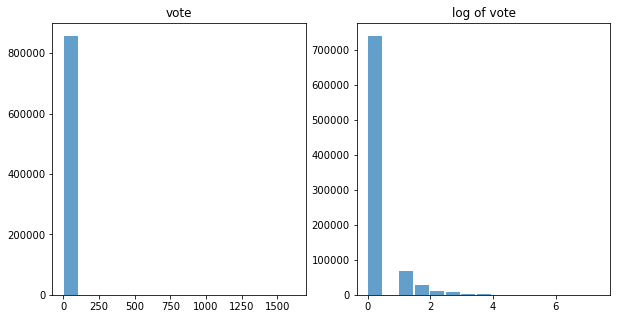

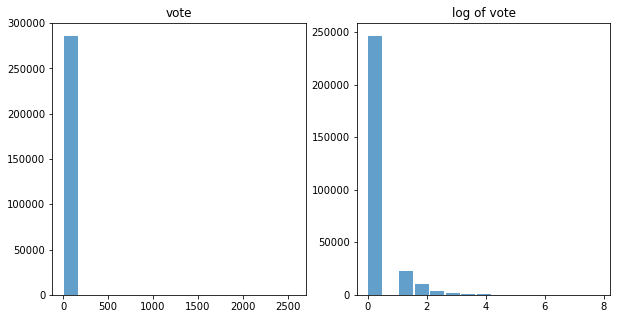

In [54]:
# Посмотрим, как влияет логарифм
val_log_plot(train, 'vote')
val_log_plot(test, 'vote')

Логарифмирование тоже не привело величину к нормальному распределению. В итоге просто разделим фичу на 2 категории: есть лайки и нет лайков.

In [55]:
train['bvote'] = train.vote.apply(lambda x: 1 if x>0 else x)
test['bvote'] = test.vote.apply(lambda x: 1 if x>0 else x)

# style

In [56]:
display(train_info[train_info.name=='style'])
display(train['style'].value_counts())
display(test_info[test_info.name=='style'])
display(test['style'].value_counts())

,name,type,count,isnull,unique,mode
9,style,object,444406,413489,25893,{'Size:': ' Pack of 1'}


{'Size:': ' Pack of 1'}                                                                    5411
{'Package Quantity:': ' 1'}                                                                4632
{'Package Type:': ' Standard Packaging'}                                                   4057
{'Size:': ' 1 Pack'}                                                                       3857
{'Size:': ' 24 Count'}                                                                     3615
                                                                                           ... 
{'Flavor:': ' Bacon Ranch'}                                                                   1
{'Size:': ' 9 pounds', 'Flavor:': ' Peru Approcassi Cajamarca FTO SHB SG Coffee Beans'}       1
{'Size:': ' 2 Pack Silver Holographic Foil Coins'}                                            1
{'Size:': ' Twelve-Pack', 'Style:': ' Cracked Wheat'}                                         1
{'Size:': ' 10 oz', 'Flavor:': ' Origina

,name,type,count,isnull,unique,mode
6,style,object,147680,138285,18905,{'Size:': ' Pack of 1'}


{'Size:': ' Pack of 1'}                                                1826
{'Package Quantity:': ' 1'}                                            1576
{'Package Type:': ' Standard Packaging'}                               1326
{'Size:': ' 1 Pack'}                                                   1312
{'Size:': ' 24 Count'}                                                 1265
                                                                       ... 
{'Size:': ' 150 Count (Pack of 2)', 'Flavor:': ' Watermelon'}             1
{'Size:': ' 12 Count', 'Flavor:': ' Blackberry Hibiscus Green Tea'}       1
{'Flavor:': ' Ceylon Earl Grey'}                                          1
{'Size:': ' 1.75 oz', 'Flavor:': ' Peppered'}                             1
{'Size:': ' 0.6-Ounce Boxes (Pack of 6)', 'Flavor:': ' Cherry'}           1
Name: style, Length: 18904, dtype: int64

В столбце лежит словарь с видом и размером упаковки, а также вкусом. Пропусков примерно половина. Сделаем дополнительный столбец с признаком наличия данных в этом столбце.   
Каким образом можно еще использовать этот столбец - непонятно.

In [57]:
train['style'] = train['style'].apply(set_None)
test['style'] = test['style'].apply(set_None)

In [58]:
train['bstyle'] = train['style'].apply(lambda x: 0 if x is None else 1)
test['bstyle'] = test['style'].apply(lambda x: 0 if x is None else 1)

## itemid

In [59]:
display(train_info[train_info.name=='itemid'])
display(train['itemid'].value_counts())
display(test_info[test_info.name=='itemid'])
display(test['itemid'].value_counts())

,name,type,count,isnull,unique,mode
11,itemid,int64,857895,0,41302,22208


22208    5491
23540    4733
24556    4654
32046    2547
5195     2300
         ... 
41186       1
39025       1
5516        1
38913       1
37017       1
Name: itemid, Length: 41302, dtype: int64

,name,type,count,isnull,unique,mode
8,itemid,int64,285965,0,37876,22208


22208    1896
24556    1574
23540    1488
32046     840
379       796
         ... 
38752       1
22136       1
15989       1
13940       1
7804        1
Name: itemid, Length: 37876, dtype: int64

Это тоже идентификатор товара. Посмотрим, как связаны между собой asin и itemid.

In [60]:
# # Проверим (не слишком строго), однозначно ли соответствуют два идентификатора друг другу
# print(len(test.groupby(['itemid','asin']).count()))
# print(len(test.groupby(['itemid']).count()))
# print(len(test.groupby(['asin']).count()))

# # >> 37876
# # >> 37876
# # >> 37876

Похоже, что два идентификатора однозначно соответствуют друг другу.

## rating

In [61]:
display(train_info[train_info.name=='rating'])
display(train['rating'].value_counts())

,name,type,count,isnull,unique,mode
12,rating,float64,857895,0,2,1


1.0    728290
0.0    129605
Name: rating, dtype: int64

Это целевая переменная. Хороших оценок значительно больше, чем плохих. Классы несбалансированы.

In [62]:
train.rating = train.rating.astype('int32')

Проверим, как полученные оценки разных видов коррелируют друг с другом.

In [63]:
display(train[train.rating == 0].overall.value_counts())
display(train[train.rating == 1].overall.value_counts())

3    60440
1    37498
2    31667
Name: overall, dtype: int64

5    615196
4    113094
Name: overall, dtype: int64

Видно, что зависимость очень жёсткая:   
Рейтинг = 0 строго соответствует оценкам 1, 2 и 3.   
Рейтинг = 1 строго соответствует оценкам 4 и 5.

# Корреляция и значимость признаков

Корреляцию и значимость проверяем для того, чтобы потом попробовать применить их в построении обычной регрессии или классификации.   
Для LightFM тщательная очистка и генерация данных не нужна. Достаточно заполнить пропуски и избавиться от дублей.

In [64]:
# Проверим поля и выделим наборы столбцов для проверки значимости столбцов
print(test.columns)
print(train.columns)

Index(['verified', 'reviewTime', 'asin', 'vote', 'style', 'userid', 'itemid',
       'Id', 'cat_age', 'bvote', 'bstyle'],
      dtype='object')
Index(['overall', 'verified', 'reviewTime', 'asin', 'reviewText', 'summary',
       'vote', 'style', 'userid', 'itemid', 'rating', 'review_polarity',
       'cat_age', 'bvote', 'bstyle'],
      dtype='object')


In [65]:
# Заново добавим в тренировочный и тестовый датафреймы данные из файла json
mtrain = pd.merge(train, meta, on='asin', how="left")
mtest = pd.merge(test, meta, on='asin', how="left")

print(mtest.columns)
print(mtrain.columns)

Index(['verified', 'reviewTime', 'asin', 'vote', 'style', 'userid', 'itemid',
       'Id', 'cat_age', 'bvote', 'bstyle', 'category', 'description', 'title',
       'brand', 'rank', 'also_view', 'main_cat', 'price', 'also_buy',
       'category_len', 'category_len_out', 'cat1', 'cat2', 'cat3', 'cat4',
       'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12',
       'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20',
       'cat_other', 'descr', 'desc_tfidf1', 'desc_tfidf2', 'brand1', 'brand2',
       'brand3', 'brand4', 'brand5', 'brand6', 'brand7', 'brand8', 'brand9',
       'brand10', 'brand11', 'brand12', 'brand13', 'brand14', 'brand15',
       'brand_other', 'rank0', 'price_log'],
      dtype='object')
Index(['overall', 'verified', 'reviewTime', 'asin', 'reviewText', 'summary',
       'vote', 'style', 'userid', 'itemid', 'rating', 'review_polarity',
       'cat_age', 'bvote', 'bstyle', 'category', 'description', 'title',
       'brand', 'rank', 'a

In [66]:
# Двоичные признаки из наборов mtrain и mtest для моделирования
bin_columns = ['verified', 'bvote', 'bstyle', 'category_len_out',
       'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 
       'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 
       'cat18', 'cat19', 'cat20', 'cat_other', 'brand1', 'brand2', 'brand3', 
       'brand4', 'brand5', 'brand6', 'brand7', 'brand8', 'brand9', 'brand10', 
       'brand11', 'brand12', 'brand13', 'brand14', 'brand15', 'brand_other']

# Числовые признаки
num_columns = ['category_len', 'cat_age', 'desc_tfidf1', 'desc_tfidf2', 'rank0', 'price_log']

# Служебные признаки
srv_columns = ['rating']

In [67]:
mtest[mtrain.desc_tfidf1.isnull()].shape

(2146, 64)

In [68]:
# Временно сольем два набора данных 
columns = bin_columns + num_columns
df_train = mtrain[columns]
df_test = mtest[columns]

data = df_test.append(df_train, sort=False).reset_index(drop=True) 

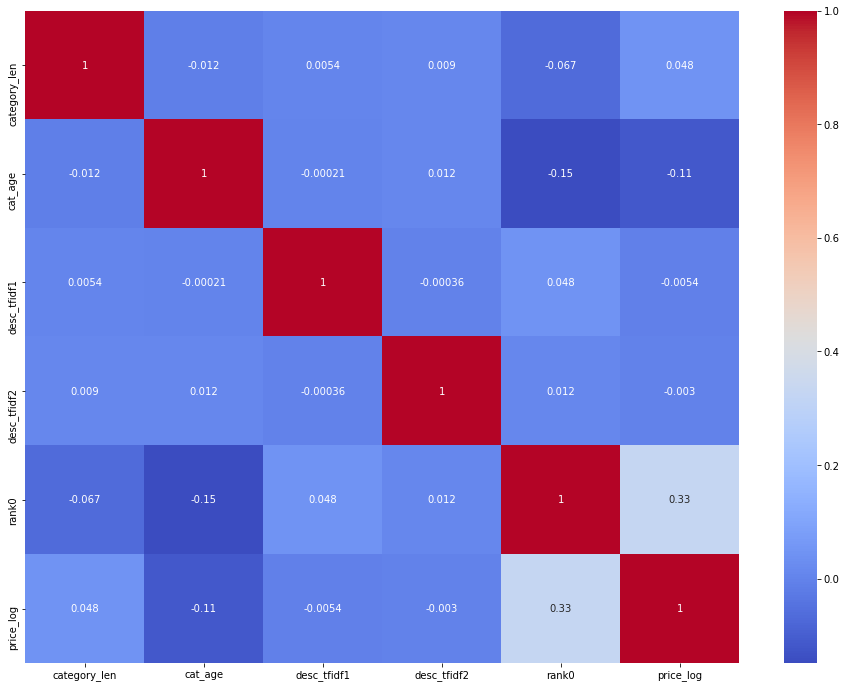

In [69]:
# Проверим корреляцию числовых столбцов в сборном датасете
correlation = data[num_columns].corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Никакие признаки между собой не коррелируют.

In [70]:
# Проверим статистическую значимость числовых столбцов по Пирсону
mtrain.desc_tfidf1 = mtrain.desc_tfidf1.fillna(0)
mtest.desc_tfidf1 = mtest.desc_tfidf1.fillna(0)
mtrain.desc_tfidf2 = mtrain.desc_tfidf2.fillna(0)
mtest.desc_tfidf2 = mtest.desc_tfidf2.fillna(0)
get_stat_corr(mtrain, num_columns, 'rating')

category_len для rating - значимость есть
cat_age для rating - значимость есть
desc_tfidf1 для rating - значимости нет
desc_tfidf2 для rating - значимость есть
rank0 для rating - значимость есть
price_log для rating - значимость есть


Преобразованное TD_IDF-анализом описание не значимо для целевой переменной rating. 

In [71]:
# Удалим столбцы с описанием из набора столбцов для модели
num_columns = ['category_len', 'cat_age', 'rank0', 'price_log']

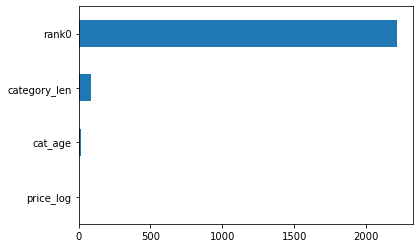

In [72]:
# Проверим значимость признаков на train с непрерывными значениями по тесту ANOVA
imp_num = Series(f_classif(mtrain[num_columns], mtrain['rating'])[0], index = num_columns)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Как видно, стоимость товара на рейтинг почти не влияет.

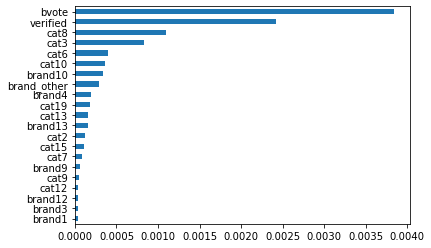

cat1                0.000000e+00
brand7              6.887301e-08
brand8              9.546313e-08
cat11               2.101547e-07
brand11             2.505723e-07
cat4                3.128189e-07
brand6              8.013760e-07
brand2              1.943144e-06
cat16               2.019325e-06
cat_other           3.040136e-06
brand15             5.320645e-06
brand14             5.660224e-06
cat20               5.991223e-06
cat18               6.135157e-06
brand5              7.880584e-06
cat5                9.363105e-06
category_len_out    1.038411e-05
cat14               1.540427e-05
cat17               1.813945e-05
bstyle              1.919955e-05
brand1              3.236768e-05
brand3              3.298881e-05
brand12             3.377896e-05
cat12               3.503244e-05
cat9                4.711899e-05
brand9              5.495453e-05
cat7                8.439818e-05
cat15               1.069673e-04
cat2                1.228612e-04
brand13             1.550127e-04
cat13     

In [73]:
# Проверим значимость двоичных признаков
imp_cat = Series(mutual_info_classif(mtrain[bin_columns], 
                                        mtrain['rating'], discrete_features = True), 
                    index=bin_columns)
imp_cat.sort_values(inplace = True)
imp_cat[20:].plot(kind = 'barh')

plt.show()

display(imp_cat)

In [74]:
# Проверим значимость признаков с дискретными значениями по критерию Стьюдента
get_stat_dif(mtrain, bin_columns, 'rating')

verified: порог=0.05, значимость есть: для (1, 0) p_value=0.0
bvote: порог=0.05, значимость есть: для (0, 1) p_value=0.0
bstyle: порог=0.05, значимость есть: для (1, 0) p_value=9.5421720748644e-09
category_len_out: порог=0.05, значимость есть: для (1.0, 0.0) p_value=2.041563513470557e-05
cat1: значимости нет
cat2: порог=0.05, значимость есть: для (0.0, 1.0) p_value=2.918311006951115e-48
cat3: порог=0.05, значимость есть: для (0.0, 1.0) p_value=1.0298676225597717e-297
cat4: порог=0.05, значимости нет
cat5: порог=0.05, значимость есть: для (0.0, 1.0) p_value=6.504064158213169e-05
cat6: порог=0.05, значимость есть: для (0.0, 1.0) p_value=5.268975922327564e-156
cat7: порог=0.05, значимость есть: для (0.0, 1.0) p_value=1.4362431878709173e-32
cat8: порог=0.05, значимость есть: для (0.0, 1.0) p_value=0.0
cat9: порог=0.05, значимость есть: для (0.0, 1.0) p_value=1.2530939091743846e-19
cat10: порог=0.05, значимость есть: для (0.0, 1.0) p_value=6.720768558878708e-146
cat11: порог=0.05, значимост

Как видно, часть dummy-столбцов оказалась незначимой. Удалим их из модели.

In [75]:
bin_columns = ['verified', 'bvote', 'bstyle', 'category_len_out',
       'cat2', 'cat3', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 
       'cat10', 'cat12', 'cat13', 'cat14', 'cat15', 'cat17', 
       'cat18', 'cat19', 'cat20', 'cat_other', 'brand1', 'brand3', 
       'brand4', 'brand5', 'brand9', 'brand10', 
       'brand12', 'brand13', 'brand14', 'brand15', 'brand_other']

# Построение моделей

## Модель 1: LightFM без использования фичей и подбора гипер-параметров

In [76]:
# Разделим тренировочный датасет на тренировочную и тестовую выборки
train_data, test_data = train_test_split(train, random_state=32, shuffle=True)

# Создадим разреженную матрицу
ratings_coo = sparse.coo_matrix((train_data['rating'],
                                 (train_data['userid'],
                                  train_data['itemid'],)))

In [77]:
LR = 0.09
NUM_THREADS = 12 #число потоков
NUM_COMPONENTS = 160 #число параметров вектора 
NUM_EPOCHS = 25 #число эпох обучения
LEARNING_SCHEDULE = 'adagrad'
LOSS_FUNCTION = 'logistic'
RANDOM_STATE = 20

In [78]:
# model = LightFM(
#     learning_rate=LR,
#     loss=LOSS_FUNCTION,
#     no_components=NUM_COMPONENTS,
#     learning_schedule = LEARNING_SCHEDULE,
#     random_state = RANDOM_STATE
# )
# model = model.fit(
#     ratings_coo,
#     epochs=NUM_EPOCHS,
#     num_threads=NUM_THREADS
# )

# preds = model.predict(test_data.userid.values, test_data.itemid.values)
# sklearn.metrics.roc_auc_score(test_data.rating, preds)

roc_auc_score = 0.7506896661428981

In [79]:
# graph_roc_auc(test_data.rating, preds)

In [80]:
# Теперь обучим модель на всем тренировочном датасете для отправки сабмита
# ratings_coo = sparse.coo_matrix((train['rating'],
#                                  (train['userid'],
#                                   train['itemid'],)))

# # Обучим модель
# model1 = LightFM(
#     learning_rate=LR,
#     loss=LOSS_FUNCTION,
#     no_components=NUM_COMPONENTS,
#     learning_schedule = LEARNING_SCHEDULE,
#     random_state = RANDOM_STATE
# )
# model1 = model1.fit(
#     ratings_coo,
#     epochs=NUM_EPOCHS,
#     num_threads=NUM_THREADS
# )

## Модель 2: LightFM подбор гипер-параметров без фичей

In [81]:
# # Заново создадим разреженную матрицу для выделенной части тренировочного набора
# ratings_coo = sparse.coo_matrix((train_data['rating'],
#                                  (train_data['userid'],
#                                   train_data['itemid'])))

In [82]:
# # Подберем гиперпараметры - сделаем выборку по двум важным параметрам:
# #     learning_rate и epochs
# for lr in np.arange(0.05, 0.12, 0.01):
#     for ne in [20,25,30]:
#         model = LightFM(learning_rate=lr, loss=LOSS_FUNCTION,
#                 no_components=NUM_COMPONENTS)
#         model = model.fit(ratings_coo, epochs=ne, 
#                   num_threads=NUM_THREADS)
#         preds = model.predict(test_data.userid.values, test_data.itemid.values)
        
#         print('lr='+str(lr)+', ne='+str(ne)+': roc_auc_score='+str(sklearn.metrics.roc_auc_score(test_data.rating,preds)))


Для модели без применения фичей оптимальными являются параметры learning_rate = 0.08/0.09 и epochs = 20.    
Также было выяснено, что результат лучше при no_components=160.

In [83]:
# Проверка модели на тренировочных данных с подобранными параметрами
model2 = LightFM(learning_rate=0.09, loss='logistic', learning_schedule = 'adagrad',
                 no_components=160, random_state = 42)
model2 = model2.fit(ratings_coo, epochs=20, 
          num_threads=NUM_THREADS)

preds2 = model2.predict(test_data.userid.values, test_data.itemid.values)
sklearn.metrics.roc_auc_score(test_data.rating, preds2)

0.7523738453488368

Для параметров learning_rate=0.09, loss='logistic', no_components=160: roc_auc_score=0.7523574465716145

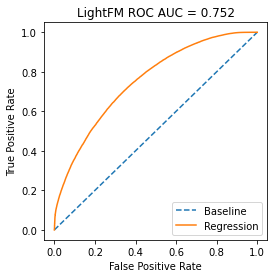

In [84]:
graph_roc_auc(test_data.rating, preds2)

In [85]:
# # Запомним эту модель и обучим ее на всем объеме train, из которого удалим дубли
# dtrain = train.drop_duplicates()
# ratings_coo = sparse.coo_matrix((dtrain['rating'],
#                                  (dtrain['userid'],
#                                   dtrain['itemid'])))

# model2 = model2.fit(ratings_coo, epochs=20, 
#           num_threads=NUM_THREADS)

## Модели 3 и 4: LightFM подбор user- и item-features

In [86]:
# meta.columns

In [87]:
# # Выберем избранные поля из метаданных для товаров
# fmeta = meta[['asin', 'rank0', 'main_cat', 'category_len','brand1', 'brand2', 'brand3',
#        'brand4', 'brand5', 'brand6', 'brand7', 'brand8', 'brand9', 'brand10',
#        'brand11', 'brand12', 'brand13', 'brand14', 'brand15', 'brand_other', 
#        'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6',
#        'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14',
#        'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat_other']] 

In [88]:
# # Сделаем dummy-переменные для категориальных признаков и создадим разреженную матрицу
# fmeta = pd.get_dummies(fmeta, columns = ['main_cat','category_len'])
# fmeta = fmeta.sort_values('asin').reset_index().drop('index', axis=1)

# meta_coo = sparse.coo_matrix(fmeta.drop('asin', axis=1).values)

**Вопрос: имело ли смысл строить item_features подобным образом?** Данный способ - просто подсунуть разреженную матрицу без добавления матрицы идентичности - был подсмотрен где-то в интернете. Какие-то оценки при этом можно получить, но эмбеддинги из этой модели не получались. Похоже, что это чушь.   
Ниже, при выдаче рекомендаций, был использован другой способ конструирования item_features.

In [89]:
# Моделируем и проверяем с item_features
# ratings_coo = sparse.coo_matrix((train_data['rating'],
#                                  (train_data['userid'],
#                                   train_data['itemid'],)))

# model3 = LightFM(loss=LOSS_FUNCTION,
#                 learning_rate=0.085,
#                 no_components=NUM_COMPONENTS)
# model3 = model3.fit(ratings_coo, epochs=20, item_features=meta_coo,
#           num_threads=NUM_THREADS)

# preds3 = model3.predict(test_data.userid.values, test_data.itemid.values, item_features=meta_coo)
# sklearn.metrics.roc_auc_score(test_data.rating, preds3)

roc_auc_score = 0.68062570004197

In [90]:
# # И снова возьмем полный набор тренировочный набор данных
# ratings_coo = sparse.coo_matrix((train['rating'],
#                                  (train['userid'],
#                                   train['itemid'],)))

# model3a = LightFM(loss='logistic',
#                 learning_rate=0.08,
#                 no_components=NUM_COMPONENTS)

# model3a = model3a.fit(ratings_coo, epochs=20, item_features=meta_coo,
#           num_threads=NUM_THREADS)

In [91]:
# Точно так же составим user_features
# train.info()

In [92]:
# # Выберем избранные признаки у train
# ftrain = train[['verified', 'bvote', 'bstyle', 'cat_age']] 

In [93]:
# # Сделаем dummy-переменные для категориальных признаков и создадим разреженную матрицу
# # ftrain = pd.get_dummies(ftrain, columns = ['main_cat','category_len'])

# train_coo = sparse.coo_matrix(ftrain.values)

In [94]:
# # Моделируем и проверяем с item_features
# model4 = LightFM(loss='logistic',
#                 learning_rate=0.08,
#                 no_components=NUM_COMPONENTS)
# model4 = model4.fit(ratings_coo, epochs=20, user_features=train_coo, item_features=meta_coo,
#           num_threads=NUM_THREADS)

# preds4 = model4.predict(test_data.userid.values, test_data.itemid.values, 
#                         user_features=train_coo, item_features=meta_coo)
# sklearn.metrics.roc_auc_score(test_data.rating, preds4)

roc_auc_score = 0.5087730254854522    
Фактически, получается простое угадывание.

In [95]:
# model4 = LightFM(loss='logistic',
#                 learning_rate=0.08,
#                 no_components=NUM_COMPONENTS)
# model4 = model4.fit(ratings_coo, epochs=20, user_features=train_coo,
#           num_threads=NUM_THREADS)

# preds4 = model4.predict(test_data.userid.values, test_data.itemid.values, 
#                         user_features=train_coo)
# sklearn.metrics.roc_auc_score(test_data.rating, preds4)

roc_auc_score = 0.5814475315967265   

Лучше отрабатывает модель с фичами товара.

## Модель 5: Регрессия

Моделью LightFM сделаем предсказания для train при помощи разбиения на фолды и поочередного предсказания для каждого фолда. Затем сделаем предсказание для test. Затем присоединим полученные предсказания к данным в виде отдельной фичи. 
    
Для моделирования будем использовать полные данные: взаимодействия (train и test) + метаданные по товарам (meta). Полные данные уже собраны в начале ноутбука и лежат в переменных mtrain и mtest. Добавление данных по товарам существенно улучшает метрику.

In [96]:
print(mtrain.columns, mtest.columns)

Index(['overall', 'verified', 'reviewTime', 'asin', 'reviewText', 'summary',
       'vote', 'style', 'userid', 'itemid', 'rating', 'review_polarity',
       'cat_age', 'bvote', 'bstyle', 'category', 'description', 'title',
       'brand', 'rank', 'also_view', 'main_cat', 'price', 'also_buy',
       'category_len', 'category_len_out', 'cat1', 'cat2', 'cat3', 'cat4',
       'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12',
       'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20',
       'cat_other', 'descr', 'desc_tfidf1', 'desc_tfidf2', 'brand1', 'brand2',
       'brand3', 'brand4', 'brand5', 'brand6', 'brand7', 'brand8', 'brand9',
       'brand10', 'brand11', 'brand12', 'brand13', 'brand14', 'brand15',
       'brand_other', 'rank0', 'price_log'],
      dtype='object') Index(['verified', 'reviewTime', 'asin', 'vote', 'style', 'userid', 'itemid',
       'Id', 'cat_age', 'bvote', 'bstyle', 'category', 'description', 'title',
       'brand', 'rank', 'a

In [97]:
# Дочистим данные
mtrain.category_len = mtrain.category_len.astype('int32')
mtrain.category_len = mtrain.category_len.fillna(0)
mtrain.cat_other = mtrain.cat_other.fillna(0)

for i in range(1,21):
    mtrain['cat'+str(i)] = mtrain['cat'+str(i)].fillna(0)

In [98]:
# Получаем предсказания методом LightFM на разбиениях K-Fold для K=5, что соответствует параметру split=0.2
kf = KFold(n_splits=5)
train_pred = pd.DataFrame(columns=['pred'])

for train_index, test_index in kf.split(train):
    X_train, X_test = train.iloc[train_index], train.iloc[test_index]
    
    # Готовим матрицу взаимодействия на очередном фолде
    ratings_coo = sparse.coo_matrix((X_train['rating'],
                                 (X_train['userid'],
                                  X_train['itemid'],))) 
    
    # Используем модель с ранее подобранными параметрами
    model2 = model2.fit(ratings_coo, epochs=20, num_threads=NUM_THREADS)
    
    # Предсказываем на отложенном фолде и проверяем метрику
    preds = model2.predict(X_test.userid.values, X_test.itemid.values)
    print(sklearn.metrics.roc_auc_score(X_test.rating, preds))
    
    # Предсказание добавляем к накопительному датафрейму и проверяем количество накопленных строк
    train_pred = pd.concat([train_pred, pd.DataFrame(preds, columns=['pred'])])
    print(len(train_pred))

0.7577652829734067
171579
0.7558643337063579
343158
0.7560782776154769
514737
0.7583290317746848
686316
0.756872583575356
857895


In [99]:
# Добавим колонку с нормализованными предсказаниями к объединенному набору тренировочных данных
pr = train_pred.pred.values
normalized_preds = (pr - pr.min())/(pr - pr.min()).max()
mtrain['pred'] = normalized_preds

In [100]:
# Заново обучим модель на всем наборе данных для тестовых данных и сделаем предсказание
dtrain = train.drop_duplicates()
ratings_coo = sparse.coo_matrix((dtrain['rating'],
                                 (dtrain['userid'],
                                  dtrain['itemid'])))

model2 = model2.fit(ratings_coo, epochs=20, num_threads=NUM_THREADS)
preds = model2.predict(test.userid.values, test.itemid.values)

# Добавим колонку с нормализованными предсказаниями к объединенному набору тестовых данных
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()
mtest['pred'] = normalized_preds

In [101]:
model_col = ['verified', 'cat_age', 'bvote','bstyle', 'category_len', 'category_len_out',
             'brand_other', 'brand10', 'cat10', 'cat6', 'cat3', 'cat8',
             'cat15','cat2', 'brand13', 'cat13', 'cat19', 'brand4',
             'rank0', 'price_log', 'pred']
# model_col = bin_columns + num_columns

In [112]:
# Построим статистики
num_feature = ['price_log', 'rank0', 'category_len']
cat_feature = ['brand', 'main_cat'] 
# cols = num_feature + cat_feature
data = mtest[num_feature].append(mtrain[num_feature], sort=False).reset_index(drop=True) # объединяем

new_columns = []

for nf in num_feature:
    for cf in cat_feature:
        
        mean_nf = data[nf].mean()
        median_nf = data[nf].median()
        max_nf = data[nf].max()
        min_nf = data[nf].min()
        std_nf = data[nf].std()
        
        print(mean_nf, median_nf, max_nf, min_nf, std_nf)

        # Среднее
        match = dict(mtrain.groupby(cf)[nf].mean())
        mtest['mean_'+cf+'_'+nf] = mtest[cf].apply(lambda x: match[x] if x in match else mean_nf )
        mtrain['mean_'+cf+'_'+nf] = mtrain[cf].apply(lambda x: match[x] if x in match else mean_nf)
        new_columns.append('mean_'+cf+'_'+nf)
        
        mtrain['mean_'+cf+'_'+nf] = mtrain['mean_'+cf+'_'+nf].fillna(mean_nf)
        mtest['mean_'+cf+'_'+nf] = mtest['mean_'+cf+'_'+nf].fillna(mean_nf)
        
        # Медиана
        match = dict(mtrain.groupby(cf)[nf].median())
        mtest['median_'+cf+'_'+nf] = mtest[cf].apply(lambda x: match[x] if x in match else median_nf )
        mtrain['median_'+cf+'_'+nf] = mtrain[cf].apply(lambda x: match[x] if x in match else median_nf)
        new_columns.append('median_'+cf+'_'+nf)
        
        mtrain['median_'+cf+'_'+nf] = mtrain['median_'+cf+'_'+nf].fillna(median_nf)
        mtest['median_'+cf+'_'+nf] = mtest['median_'+cf+'_'+nf].fillna(median_nf)
        
        # Максимум
        match = dict(mtrain.groupby(cf)[nf].max())
        mtest['max_'+cf+'_'+nf] = mtest[cf].apply(lambda x: match[x] if x in match else max_nf )
        mtrain['max_'+cf+'_'+nf] = mtrain[cf].apply(lambda x: match[x] if x in match else max_nf )
        new_columns.append('max_'+cf+'_'+nf)
        
        mtrain['max_'+cf+'_'+nf] = mtrain['max_'+cf+'_'+nf].fillna(max_nf)
        mtest['max_'+cf+'_'+nf] = mtest['max_'+cf+'_'+nf].fillna(max_nf)
        
        # Минимум
        match = dict(mtrain.groupby(cf)[nf].min())
        mtest['min_'+cf+'_'+nf] = mtest[cf].apply(lambda x: match[x] if x in match else min_nf )
        mtrain['min_'+cf+'_'+nf] = mtrain[cf].apply(lambda x: match[x] if x in match else min_nf)
        new_columns.append('min_'+cf+'_'+nf)
        
        mtrain['min_'+cf+'_'+nf] = mtrain['min_'+cf+'_'+nf].fillna(min_nf)
        mtest['min_'+cf+'_'+nf] = mtest['min_'+cf+'_'+nf].fillna(min_nf)
        
        # Разброс
        match = dict(mtrain.groupby(cf)[nf].std())
        mtest['std_'+cf+'_'+nf] = mtest[cf].apply(lambda x: match[x] if x in match else std_nf )
        mtrain['std_'+cf+'_'+nf] = mtrain[cf].apply(lambda x: match[x] if x in match else std_nf)
        new_columns.append('std_'+cf+'_'+nf)
        
        mtrain['std_'+cf+'_'+nf] = mtrain['std_'+cf+'_'+nf].fillna(std_nf)
        mtest['std_'+cf+'_'+nf] = mtest['std_'+cf+'_'+nf].fillna(std_nf)

2.968307106533193 3.202339856228101 6.906754778648554 -4.605170185988091 0.5438853288895314
2.968307106533193 3.202339856228101 6.906754778648554 -4.605170185988091 0.5438853288895314
10.417180679884687 10.752248627616684 15.089056905154903 1.3862943611198906 2.1183559445595854
10.417180679884687 10.752248627616684 15.089056905154903 1.3862943611198906 2.1183559445595854
4.05461594950431 4.0 11 2 0.7454238746929323
4.05461594950431 4.0 11 2 0.7454238746929323


In [103]:
# dict(mtrain.groupby('brand')['price_log'].mean())

In [113]:
mtrain.columns

Index(['overall', 'verified', 'reviewTime', 'asin', 'reviewText', 'summary',
       'vote', 'style', 'userid', 'itemid', 'rating', 'review_polarity',
       'cat_age', 'bvote', 'bstyle', 'category', 'description', 'title',
       'brand', 'rank', 'also_view', 'main_cat', 'price', 'also_buy',
       'category_len', 'category_len_out', 'cat1', 'cat2', 'cat3', 'cat4',
       'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12',
       'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20',
       'cat_other', 'descr', 'desc_tfidf1', 'desc_tfidf2', 'brand1', 'brand2',
       'brand3', 'brand4', 'brand5', 'brand6', 'brand7', 'brand8', 'brand9',
       'brand10', 'brand11', 'brand12', 'brand13', 'brand14', 'brand15',
       'brand_other', 'rank0', 'price_log', 'pred', 'mean_brand_price_log',
       'median_brand_price_log', 'max_brand_price_log', 'min_brand_price_log',
       'std_brand_price_log', 'mean_main_cat_price_log',
       'median_main_cat_price_log', 'm

In [110]:
# mtrain = mtrain.drop(['mean_main_cat_price_log',
#        'median_main_cat_price_log', 'max_main_cat_price_log',
#        'min_main_cat_price_log', 'std_main_cat_price_log',
#        'mean_main_cat_rank0', 'median_main_cat_rank0', 'max_main_cat_rank0',
#        'min_main_cat_rank0', 'std_main_cat_rank0',
#        'mean_main_cat_category_len', 'median_main_cat_category_len',
#        'max_main_cat_category_len', 'min_main_cat_category_len',
#        'std_main_cat_category_len'], axis=1)
# mtest = mtest.drop(['mean_main_cat_price_log',
#        'median_main_cat_price_log', 'max_main_cat_price_log',
#        'min_main_cat_price_log', 'std_main_cat_price_log',
#        'mean_main_cat_rank0', 'median_main_cat_rank0', 'max_main_cat_rank0',
#        'min_main_cat_rank0', 'std_main_cat_rank0',
#        'mean_main_cat_category_len', 'median_main_cat_category_len',
#        'max_main_cat_category_len', 'min_main_cat_category_len',
#        'std_main_cat_category_len'], axis=1)

In [114]:
# mtrain[mtrain.std_brand_category_len.isnull()].brand.count()

0

In [115]:
cols = model_col + new_columns
print(cols)

['verified', 'cat_age', 'bvote', 'bstyle', 'category_len', 'category_len_out', 'brand_other', 'brand10', 'cat10', 'cat6', 'cat3', 'cat8', 'cat15', 'cat2', 'brand13', 'cat13', 'cat19', 'brand4', 'rank0', 'price_log', 'pred', 'mean_brand_price_log', 'median_brand_price_log', 'max_brand_price_log', 'min_brand_price_log', 'std_brand_price_log', 'mean_main_cat_price_log', 'median_main_cat_price_log', 'max_main_cat_price_log', 'min_main_cat_price_log', 'std_main_cat_price_log', 'mean_brand_rank0', 'median_brand_rank0', 'max_brand_rank0', 'min_brand_rank0', 'std_brand_rank0', 'mean_main_cat_rank0', 'median_main_cat_rank0', 'max_main_cat_rank0', 'min_main_cat_rank0', 'std_main_cat_rank0', 'mean_brand_category_len', 'median_brand_category_len', 'max_brand_category_len', 'min_brand_category_len', 'std_brand_category_len', 'mean_main_cat_category_len', 'median_main_cat_category_len', 'max_main_cat_category_len', 'min_main_cat_category_len', 'std_main_cat_category_len']


In [116]:
# Модель 5: логистическая регрессия с подобранными в GridSearch параметрами.
# Код подбора приводится ниже.
X = mtrain[cols]
y = mtrain.rating

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

model5 = LogisticRegression(random_state=42, penalty='l2', solver='newton-cg', C=1)
model5.fit(X_train, y_train)
preds_prob = model5.predict_proba(X_test)[:,1]

sklearn.metrics.roc_auc_score(y_test, preds_prob)

# 0.7667108324888396  'category_len', 'category_len_out'
# 0.7681307315889272  'category_len', 'category_len_out' + вторая строка
# 0.7682855739694459  'category_len', 'category_len_out' + вторая и третья строки
# 0.7666946539317812

0.7687471872232488

Метрика с подобранными параметрами:   
roc_auc_score = 0.7683407551212319

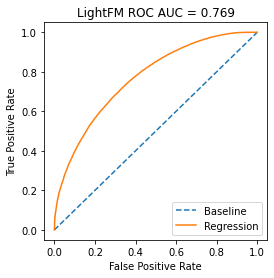

In [118]:
graph_roc_auc(y_test, preds_prob)

In [ ]:
# Подбор гиперпараметров для логистической регрессии

# # GridSearch на итерациях max_iter=100 и с штатной дельтой останова tol = 0.0001
# from sklearn.model_selection import GridSearchCV

# bmodel = LogisticRegression(random_state=42)
# iteration = 100
# stop = 0.0001
# parameters = [
#     {'penalty': ['l1'], 
#      'solver': ['liblinear', 'lbfgs'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iteration],
#      'tol':[stop]},
#     {'penalty': ['l2'], 
#      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iteration],
#      'tol':[stop]},
#     {'penalty': ['none'], 
#      'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iteration],
#      'tol':[stop]},
    
# ]
# gridsearch = GridSearchCV(bmodel, parameters, scoring='f1', n_jobs=-1, cv=5)
# gridsearch.fit(X_train, y_train)
# bmodel = gridsearch.best_estimator_

# # Выводим параметры
# best_parameters = bmodel.get_params()
# for param_name in sorted(best_parameters.keys()):
#         print('\t%s: %r' % (param_name, best_parameters[param_name]))
        
# # Выводим метрики
# preds_prob = bmodel.predict_proba(X_test)[:,1]
# sklearn.metrics.roc_auc_score(y_test, preds_prob)

In [119]:
# Обучаем модель на всем объеме тренировочных данных для сабмита
model5.fit(X, y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# # Модель 6: RandomForestRegressor
# model6 = RandomForestRegressor(random_state=42)
# model6.fit(X_train, y_train)
# preds6 = model6.predict(X_test)

# sklearn.metrics.roc_auc_score(y_test, preds6)

Без подбора параметров roc_auc_score = 0.7349815521638858

In [ ]:
# # Подбор оптимальных параметров для RandomForest

# param_grid = {'n_estimators': [100, 200, 300, 400],
#                'max_features': ['auto', 'sqrt'],
#                'max_depth': [8, 10, 12] + [None],
#                'min_samples_split': [5, 10],
#                'min_samples_leaf': [1, 2],
#                'bootstrap': [True, False]}

# grid_search_result = RandomizedSearchCV(estimator = model6, 
#                                         param_distributions = param_grid, 
#                                         n_iter = 50, 
#                                         cv = 3, 
#                                         verbose=10, 
#                                         random_state=42, 
#                                         n_jobs = -1)
# grid_search_result.fit(X_train, y_train)
# grid_search_result.best_params_

# # Нашли лучшие параметры:
# # {'n_estimators': 300,
# #  'min_samples_split': 10,
# #  'min_samples_leaf': 1,
# #  'max_features': 'sqrt',
# #  'max_depth': None,
# #  'bootstrap': False}

In [ ]:
# model6 = RandomForestRegressor(random_state=42, n_estimators=300,
#                               min_samples_split=10, min_samples_leaf=1,
#                               max_features='sqrt',max_depth=None, bootstrap=False)
# model6.fit(X_train, y_train)
# preds6 = model6.predict(X_test)
# sklearn.metrics.roc_auc_score(y_test, preds6)


С подбором параметров метрика почти не изменилась:    
roc_auc_score = 0.7393271135459103

In [ ]:
# Модель 7: XGB
# Параметры подобраны при помощи кода ниже.
# model7 = xgb.XGBRegressor(learning_rate=0.05, 
#                           min_samples_split=10,
#                           max_depth=None, 
#                           min_samples_leaf = 1,
#                           max_features = 'sqrt',
#                           bootstrap=False,
#                           n_estimators=300)


# model7.fit(X_train, y_train)
# preds7 = model7.predict(X_test)
# sklearn.metrics.roc_auc_score(y_test, preds7)

Подбор параметров улучшил метрику:   
roc_auc_score = 0.7728151666703905   
Однако при сабмите результат получился хуже, чем у логистической регрессии.

In [ ]:
# Обучаем модель на всем объеме тренировочных данных для сабмита
# model7.fit(X, y)

In [ ]:
# # Подбор параметров для XGB
# param_grid = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['reg:squarederror'],
#               'learning_rate': [0.03, 0.05, 0.07], 
#               'max_depth': [10, 12, 14],
#               'alpha': [0, 1],
#               'colsample_bytree': [0.3, 0.5, 0.7],
#               'n_estimators': [1000]}

# xgbRegr = xgb.XGBRegressor()
# grid_search_result = GridSearchCV(xgbRegr,
#                         param_grid,
#                         cv = 2,
#                         n_jobs = -1,
#                         verbose=True)

# grid_search_result.fit(X_train, y_train)
# print(grid_search_result.best_params_)

В итоге для финального сабмита была использована логистическая регрессия. Результат на момент сдачи проекта: 7 место.  
     
Можно было еще улучшить результат, вводя дополнительные фичи, например, нагенерить их из reviewTime, но непонятно, для чего это нужно. Практического применения данного предсказания именно для выдачи рекомендаций я не вижу. Поэтому дальнейшее улучшение не проводилось.    
    
**Вопрос: как в выдаче рекомендаций можно использовать такую модель и полученные с ее помощью предсказания?** Можно ли вообще ее к чему-нибудь пррактически применить?

# Использование модели для рекомендации товаров

In [120]:
# Добавим в meta столбец itemid
df_tr = mtrain[['asin', 'itemid']]
df_te = mtest[['asin', 'itemid']]

data = df_te.append(df_tr, sort=False).reset_index(drop=True) 
data = data.drop_duplicates()

mapper = dict(zip(data['asin'],data['itemid']))
meta['itemid'] = meta.asin.apply(lambda x: mapper[x] if x in mapper else 0)

In [121]:
# Превратим в список столбец also_buy, 
# он нам тоже пригодится для рекомендаций
meta['also_buy'] = meta['also_buy'].apply(set_None)
meta['also_buy'] = meta['also_buy'].fillna('')
meta['also_buy'] = meta['also_buy'].apply(lambda x: x.replace("[", "").replace("]", "").replace("'", ""))
meta['also_buy'] = meta['also_buy'].apply(lambda x: x.split(", "))

# Получим развернутый датасет с совместными покупками
meta_also_buy = meta[['also_buy','asin', 'itemid']].explode('also_buy')

In [122]:
# Подготовим item_features по рекомендациям из Slack

# # Шаг 1. Вы имеете item_features в виде датафрейма с текстовыми и числовыми значениями
# fmeta = meta[['itemid', 'rank0', 'main_cat', 'category_len']]
fmeta1 = meta[['main_cat']]
fmeta2 = meta[['category_len']]

# # Шаг 2. Делаете one_hot кодирование категориальных признаков и нормируем числовые признаки.
fmeta1 = pd.get_dummies(fmeta1, columns = ['main_cat'])
fmeta2 = pd.get_dummies(fmeta2, columns = ['category_len'])

# # Шаг 3. Преобразуем датафрейм в numpy-массив: 
item_features1 = np.array(fmeta1)
ifeat1 = (sparse.coo_matrix(item_features1))
item_features2 = np.array(fmeta2)
ifeat2 = (sparse.coo_matrix(item_features2))

# # Шаг 4. Добавляем матрицу идентичности:
# item_features = np.concatenate([item_features, np.identity(len(item_features))],axis=1) # не работает, зависает намертво
meta_coo = scipy.sparse.identity(len(item_features1), format='coo')

# # Шаг 5. Передаем item_features в метод .fit()
ifeat = sparse.hstack([ifeat1,ifeat2,meta_coo]) #ifeat1,


In [123]:
# Моделируем и проверяем с item_features
ratings_coo = sparse.coo_matrix((train_data['rating'],
                                 (train_data['userid'],
                                  train_data['itemid'])))

model3 = LightFM(loss=LOSS_FUNCTION,
                learning_rate=0.085,
                no_components=NUM_COMPONENTS)
model3 = model3.fit(ratings_coo, epochs=20, 
                    #item_features=ifeat, 
                    num_threads=NUM_THREADS)

preds3 = model3.predict(test_data.userid.values, test_data.itemid.values)# , item_features = ifeat)
sklearn.metrics.roc_auc_score(test_data.rating, preds3)

0.7512323493107615

Итоги проверки:   
Если не указывать параметр item_features, то roc_auc_score = 0.7518689542804393      
Если взять только одну фичу main_cat, то roc_auc_score = 0.7244363823355222     
Если взять только одну фичу category_len, то roc_auc_score = 0.7055578632744148   
Если взять обе фичи, то roc_auc_score = 0.7102272103639333

**Вопрос: что полезного в добавлении item_features для выдачи рекомендаций?** Остался непонятым смысл добавления item_features.

In [124]:
# Тренируем на всем объеме данных
ratings_coo = sparse.coo_matrix((train['rating'],
                                 (train['userid'],
                                  train['itemid'])))

model3 = LightFM(loss=LOSS_FUNCTION,
                learning_rate=0.085,
                no_components=NUM_COMPONENTS)
model3 = model3.fit(ratings_coo, epochs=20 , item_features=ifeat, 
          num_threads=NUM_THREADS)

In [ ]:
# # Проверка эмбеддингов
# item_biases, item_embeddings = model3.get_item_representations()
# item_biases.shape, item_embeddings.shape

In [125]:
# Функция определения ближайших товаров 
def get_similar_items(model, itemid, topN):
    # Define similarity as the cosine of the angle
    # between the item latent vectors

    # Normalize the vectors to unit length
    item_embeddings = (model.item_embeddings.T
                      / np.linalg.norm(model.item_embeddings, axis=1)).T

    one_embedding = item_embeddings[itemid]
    similarity = np.dot(item_embeddings, one_embedding)
    most_similar = np.argsort(-similarity)[1:topN+1]

    return most_similar

# gst = get_similar_items(model3, 13952, 10)
# mtrain[mtrain.itemid.isin(gst)].title.unique()

Данная функция была предложена вот здесь: https://making.lyst.com/lightfm/docs/examples/hybrid_crossvalidated.html#bonus-tag-embeddings. Она работает быстрее, чем выбор ближайших соседей через nmslib и не требует установки дополнительных библиотек. Эксперименты с обоими вариантами поиска наиболее близких товаров показали, что оба варианта рекомендуют практически одно и то же.   

**Вопрос: какие подводные камни могут обнаружиться при нахождении наиболее похожих товаров таким вот образом?** Почему nmslib лучше?

In [128]:
# Функция для выдачи рекомендаций
def get_recommendation(model, itemid, topN=10):
    # Датафрейм для накопления рекомендаций
    rec_items = pd.DataFrame(columns=['title','description','rec_type'])
    
    # Проверка входного товара для рекомендаций
    df = meta[meta.itemid==itemid]
    ln = len(df)
    
    if ln > 0: 
        # Входной товар
        rec_items.loc[0] = [meta[meta.itemid==itemid].title.iloc[0], 
                        meta[meta.itemid==itemid].description.iloc[0],
                       'input_item']
          
        # Находим наиболее похожие при моделировании
        gst = get_similar_items(model, itemid, topN)
        if len(gst) > 0:
            df = meta[meta.itemid.isin(gst)][['title','description']]
            df['rec_type'] = 'prediction'
            rec_items = pd.concat([rec_items, df])
          
        # Находим товары того же бренда с наилучшими оценками
        brand = meta[meta.itemid==itemid].brand.iloc[0]
        if brand != 'Unknown':
            df = mtrain[(mtrain.brand==brand) & \
                        (mtrain.itemid!=itemid) & \
                        (mtrain.verified==1)].sort_values(by='overall', ascending=False)
            df = df[['title', 'description']].drop_duplicates(subset=['title']).iloc[:topN]
            df['rec_type'] = 'brand'
            rec_items = pd.concat([rec_items, df])

        # Находим товары той же категории с наилучшими оценками
        main_cat = meta[meta.itemid==itemid].main_cat.iloc[0]
        category = meta[meta.itemid==itemid].category.iloc[0]
        if brand != 'Unknown':
            df = mtrain[(mtrain.category==category) & \
                        (mtrain.brand!=brand) & \
                        (mtrain.verified==1)].sort_values(by='overall', ascending=False)
            df = df[['title', 'description']].drop_duplicates(subset=['title']).iloc[:topN]
            df['rec_type'] = 'category'
            rec_items = pd.concat([rec_items, df])
            
        # Находим товары, которые покупали с входным товаром
        ab_list = meta_also_buy[meta_also_buy.itemid==itemid].also_buy.unique()
        dg = mtrain[mtrain.asin.isin(ab_list)].sort_values(by='overall', ascending=False)
        # Сортируем их по лучшим оценкам
        dg = dg[['title', 'description']].drop_duplicates(subset=['title']).iloc[:topN]
        dg['rec_type'] = 'also buy'
        rec_items = pd.concat([rec_items, dg])
        
        # Находим товары с наилучшими отзывами
        df = mtrain[(mtrain.overall==5) & \
                    (mtrain.verified==1)].sort_values(by='review_polarity', ascending=False)
        df = df[['title', 'description']].drop_duplicates(subset=['title']).iloc[:topN*2]
        df['rec_type'] = 'best review'
        rec_items = pd.concat([rec_items, df])        
    else:
        # Входной товар не найден
        rec_items.loc[0] = ['Товар не найден', 
                        None,
                       'not found']  

        # Находим товары с наилучшими оценками и самым большим количеством отзывов
        df = mtrain[(mtrain.overall==5) & \
                    (mtrain.verified==1)].sort_values(by='vote', ascending=False)
        df = df[['title', 'description']].drop_duplicates(subset=['title']).iloc[:topN*2]
        df['rec_type'] = 'popular'
        rec_items = pd.concat([rec_items, df])
        
        # Находим товары с наилучшими отзывами
        df = mtrain[(mtrain.overall==5) & \
                    (mtrain.verified==1)].sort_values(by='review_polarity', ascending=False)
        df = df[['title', 'description']].drop_duplicates(subset=['title']).iloc[:topN*2]
        df['rec_type'] = 'best review'
        rec_items = pd.concat([rec_items, df])
    
    return rec_items

Так же можно предложить товары из столбца 'also_view' и 'similar_item'.     
Можно также собрать побольше товаров способом - штук 500 - указанным в функции способом, и их тоже прогнать через какую-нибудь модель совокупно с исходным товаром для кластеризации. И предложить товары из одного кластера с исходным.    

**Вопрос: что делать, если рекомендацию надо выдать в паре к новому товару, который ранеее не оценивался и не входит в матрицу взаимодействия?** Этот тоже осталось непонятым.

In [129]:
# проверка рекомендаций
get_recommendation(model3, 21654, 6)

,title,description,rec_type
0,"The Spice Hunter Jamaican Allspice, Ground, 1....","['allspice, ground from jamaica is all natural...",input_item
76324,"Jelly Belly Beans, Grape Crush, 1 Pound",['jelly belly grape flavored jelly beans in bu...,prediction
80253,"Mio Mango And Peach Liquid Water Enhancer, 1.6...",['mio peach mango liquid water enhancerjust fr...,prediction
134156,"Orville Redenbacher's Poppycock Original, 10.5 oz","['ingredients mixed nuts, (almonds, pecans), c...",prediction
231573,Cocoa Puffs Chocolate Cereal 20.9 oz Box,"['cocoa puffs chocolate cereal 20.9 oz. box', ...",prediction
241493,"Celestial Seasonings Herbal Tea, Tension Tamer...",['100% natural herb tea. sip away the stress o...,prediction
279901,"Yankee Traders Brand Whole Allspice, 1 Pound",['yankee traders brand allspice. allspice is o...,prediction
1375,"The Spice Hunter Garam Masala Blend, 1.8-Ounce...","['garam masala, an aromatic blend of herbs and...",brand
519566,"The Spice Hunter Juniper Berries Whole, 1.3-Ou...",['the spice hunter juniper berries whole comes...,brand
553513,"The Spice Hunter Mexican Seasoning, Organic, 1...",['this savory blend of organic spices and herb...,brand


In [ ]:
# # Второй вариант поиска ближайших товаров для рекомендации


# # Создаём граф для поиска
# nms_idx = nmslib.init(method='hnsw', space='cosinesimil')
 
# #Начинаем добавлять товары в граф
# nms_idx.addDataPointBatch(item_embeddings)
# nms_idx.createIndex(print_progress=True)

# # Вспомогательная функция для поиска по графу
# def nearest_item_nms(itemid, index, n=10):
#     nn = index.knnQuery(item_embeddings[itemid], k=n)
#     return nn

# nbm = nearest_item_nms(13952,nms_idx, n=6)[0]
# print(nbm)

# # Выводим похожие товары.
# meta[meta.itemid.isin(nbm)].title.unique()[1:]


# Submission

In [130]:
# preds1 = model1.predict(test.userid.values, test.itemid.values)
# preds2 = model2.predict(test.userid.values, test.itemid.values)
# preds3 = model3.predict(test.userid.values, test.itemid.values, item_features=meta_coo)
# preds3a = model3a.predict(test.userid.values, test.itemid.values, item_features=meta_coo)


# normalized_preds1 = (preds1 - preds1.min())/(preds1 - preds1.min()).max()
# normalized_preds2 = (preds2 - preds2.min())/(preds2 - preds2.min()).max()
# normalized_preds3 = (preds3 - preds3.min())/(preds3 - preds3.min()).max()
# normalized_preds3a = (preds3a - preds3a.min())/(preds3a - preds3a.min()).max()

df_test = mtest[cols]
preds_prob5 = model5.predict_proba(df_test)[:,1]
# preds7 = model7.predict(df_test)
# normalized_preds7 = (preds7 - preds7.min())/(preds7 - preds7.min()).max()

In [131]:
submission_pred = submission.copy()


# submission_pred['rating']= normalized_preds1
# submission_pred.to_csv('submission_1.csv', index=False)

# submission_pred['rating']= normalized_preds2
# submission_pred.to_csv('submission_2.csv', index=False)

# submission_pred['rating']= normalized_preds3
# submission_pred.to_csv('submission_3.csv', index=False)

# submission_pred['rating']= normalized_preds3a
# submission_pred.to_csv('submission_3a.csv', index=False)

submission_pred['rating']= preds_prob5
submission_pred.to_csv('submission_preds_prob5.csv', index=False)

# submission_pred['rating']= normalized_preds7
# submission_pred.to_csv('submission_7.csv', index=False)

# submission_pred['rating']= normalized_preds
# submission_pred.to_csv('submission_norm_pred.csv', index=False)

# submission_pred['rating']= preds
# submission_pred.to_csv('submission_pred.csv', index=False)